In [1]:
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.functional as F

In [2]:
import cv2
import PIL.Image as Image

In [3]:
data_rootdir = "G:\\KITTI\\tracking"

In [4]:
ls = os.listdir(data_rootdir)

In [5]:
calib_dir = data_rootdir + "\\" + ls[0]
image_left_dir = data_rootdir + "\\" + ls[1]
image_right_dir = data_rootdir + "\\" + ls[2]
label_dir = data_rootdir + "\\" + ls[3]
oxts_dir = data_rootdir + "\\" + ls[4]
vel_dir = data_rootdir + "\\" + ls[5]

In [6]:
image_left_train = image_left_dir + "\\" + "training\\image_02"
image_right_train = image_right_dir + "\\" + "training\\image_03"

In [7]:
def nothing(emp):
    pass

def jindu_imgpath(name, frames):
    cv2.namedWindow(name,0)
    cv2.resizeWindow(name, 1242, 375)
    loop_flag = 0
    pos = 0
    cv2.createTrackbar('time', name, 0, frames, nothing)
    path_list = os.listdir(img_path)
    for m, img in enumerate(path_list):
        img_file = img_path + '\\' + img
        img_new = cv2.imread(img_file)
        if cv2.waitKey(20) == ord('q'):
            break;
        if loop_flag == pos:
            loop_flag = loop_flag + 1
            cv2.setTrackbarPos('time', name, loop_flag)
        else:
            pos = cv2.getTrackbarPos('time', name)
            loop_flag = pos
        img = path_list[loop_flag]
        img_file = img_path + '/' + img
        img_new = cv2.imread(img_file)
        cv2.imshow(name, img_new)

In [8]:
img_path = image_left_train + r'\\0000'
frames = len(os.listdir(img_path))
jindu_imgpath('img', frames)
cv2.destroyAllWindows()

可以看出来KITTI数据集每一个duration就是一个连续拍摄的视频片段
opencv读取图片是BGR

In [9]:
import pykitti

In [10]:
train_root = "G:\\KITTI\\tracking\\training"

In [11]:
os.listdir(train_root)

['calib', 'image_02', 'image_03', 'label_02', 'oxts', 'velodyne']

In [12]:
data = pykitti.tracking(train_root, "0000")

files 154


In [13]:
type(data)

pykitti.tracking.tracking

In [14]:
data.base_path

'G:\\KITTI\\tracking\\training'

In [15]:
data.cam2
# 返回一个迭代器

<generator object yield_images at 0x0000017FB8362CC8>

In [89]:
type(data.get_cam2(0))
# 根据idx，返回单张图片

PIL.Image.Image

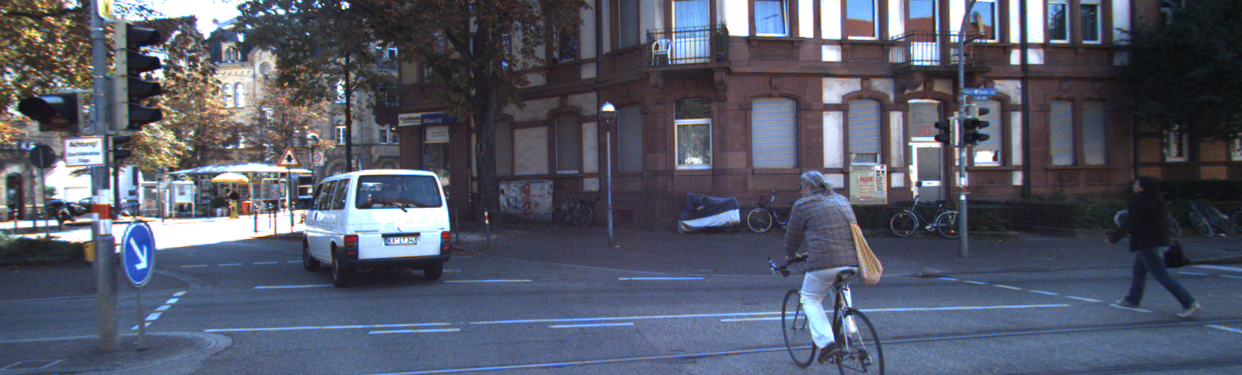

In [17]:
data.get_rgb(0)[0]
# 返回某时刻的左右图像

In [18]:
label_root = train_root + '\\label_02\\0000.txt'

In [19]:
label = pykitti.KittiTrackingLabels(label_root)

In [20]:
label

In [21]:
type(label)

pykitti.tracking.KittiTrackingLabels

In [22]:
label.bbox.shape
# 这里的154代表的是154帧图像，每一帧图像中都有一定数量的bounding box
# bbox表示的2D box

(154,)

In [23]:
label.bbox[0]
# （n，4），4个小项目分别对应了 x y width height

array([[ 296.74496,  161.75215,  158.48108,  130.62065],
       [ 737.6195 ,  161.53195,  193.49274,  212.46805],
       [1106.1373 ,  166.57681,   98.33325,  157.29932]], dtype=float32)

In [24]:
type(label.bbox[0][0])

numpy.ndarray

In [25]:
# 绘制二维框图
def frow_box2d(img_path, boxes):
    cv2.namedWindow('img', 0)
    cv2.resizeWindow('img', 1242, 375)
    img = cv2.imread(img_path)
    for box in boxes:
        r = np.random.randint(0, 256)
        g = np.random.randint(0, 256)
        b = np.random.randint(0, 256)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (b, g, r), 5)
    cv2.imshow('img', img)
    if cv2.waitKey(0) == ord('q'):
        pass

In [26]:
boxes = []
for box in label.bbox[0]:
    boxes.append([box[0], box[1], box[0]+box[2], box[1]+box[3]])

In [27]:
boxes

[[296.74496, 161.75215, 455.22604, 292.3728],
 [737.6195, 161.53195, 931.11224, 374.0],
 [1106.1373, 166.57681, 1204.4706, 323.87613]]

In [28]:
img_path = train_root + '\\image_02\\0000\\000000.png'
frow_box2d(img_path, boxes)
cv2.destroyAllWindows()

**如何绘制三维框图**

In [29]:
import kitti_object_tracking
import kitti_util_tracking

In [30]:
train_root = 'G:\\KITTI\\tracking'

In [31]:
kitti_object = kitti_object_tracking.kitti_object_tracking(train_root)

In [32]:
kitti_object.calib_dir

'G:\\KITTI\\tracking\\training\\calib'

In [33]:
calib_object = kitti_object.get_calibration('0000')

In [34]:
calib_object

In [35]:
label_object = kitti_object.get_label_objects('0000')
# 这里读取了label_object
# 每一个label——object中都包含有一个 duration 的label
# 这些label被组织为一个一个的object，以列表的形式组织

In [36]:
len(label_object)

711

In [37]:
label_object[0]

In [38]:
calib_object.P

array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
       [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
       [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]])

In [39]:
box_3d = kitti_util_tracking.compute_box_3d(label_object[0], calib_object.P)
boxes_3d = []
num = len([x for x in label_object if x.frame_idx==0])
for x in label_object[:num]:
    boxes_3d.append(kitti_util_tracking.compute_box_3d(x, calib_object.P))
# 这里得到了三维框图在二维图像相机2中的坐标位置

In [42]:
boxes_3d

[(array([[297.30680458, 263.21837084],
         [387.29467934, 257.8089683 ],
         [455.25473172, 284.68002864],
         [340.18233601, 294.24521532],
         [297.30680458, 165.95642984],
         [387.29467934, 166.36933299],
         [455.25473172, 164.31824779],
         [340.18233601, 163.58813098]]),
  array([[-6.48070602,  1.858523  , 14.83425393],
         [-4.92129955,  1.858523  , 15.77898154],
         [-2.62386198,  1.858523  , 11.98673607],
         [-4.18326845,  1.858523  , 11.04200846],
         [-6.48070602, -0.141477  , 14.83425393],
         [-4.92129955, -0.141477  , 15.77898154],
         [-2.62386198, -0.141477  , 11.98673607],
         [-4.18326845, -0.141477  , 11.04200846]])),
 (array([[739.94769611, 355.35004524],
         [826.4605624 , 353.00702545],
         [931.77807533, 417.82956192],
         [815.45443418, 422.18242999],
         [739.94769611, 165.90831705],
         [826.4605624 , 165.99749089],
         [931.77807533, 163.53038654],
         [

In [47]:
img = kitti_object.get_image('0000', 0)
cv2.namedWindow('theimage')
cv2.destroyAllWindows()

In [91]:
img.shape

(375, 1242, 3)

In [48]:
for x in range(3):
    img_with_boundingBox = kitti_util_tracking.draw_projected_box3d(img, boxes_3d[x][0])

In [50]:
cv2.imshow('theimage', img_with_boundingBox)
cv2.waitKey(0)
cv2.destroyAllWindows()

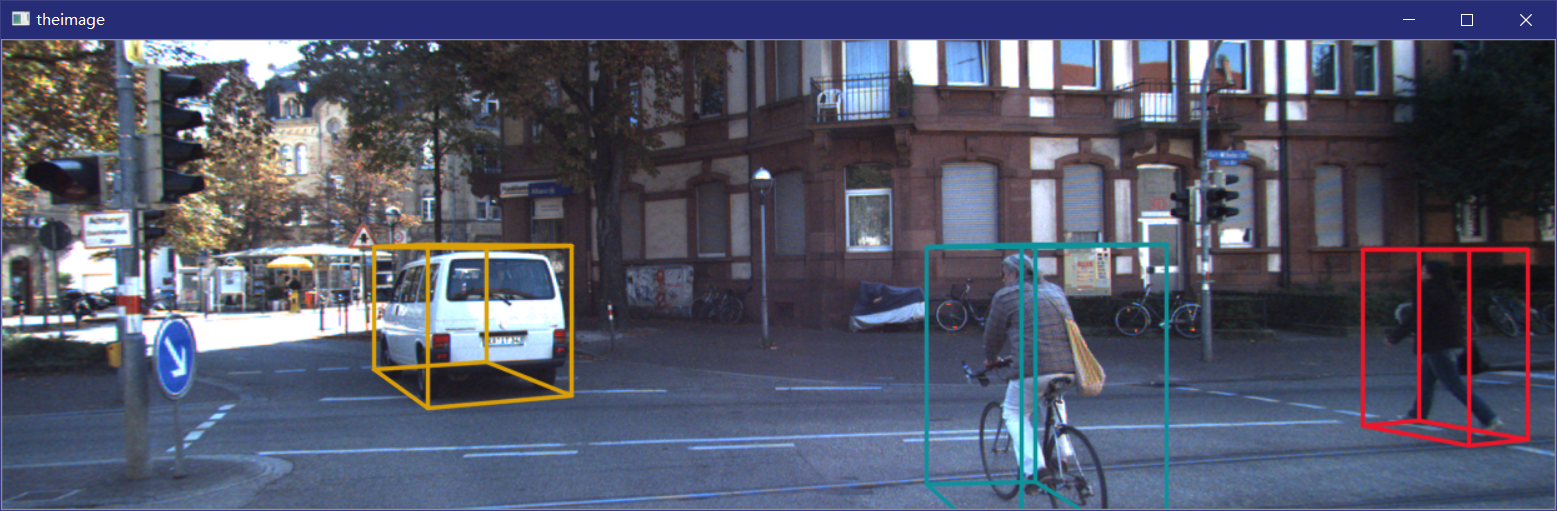

In [53]:
orientation = kitti_util_tracking.compute_orientation_3d(label_object[0], calib_object.P)

In [61]:
orientation[0][0]
# orientation指示的是方向

array([324.81589034, 250.77892033])

In [66]:
img2 = cv2.line(img_with_boundingBox, (367,272), (324, 250), (255,255,255), 5)
cv2.imshow('theimage', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

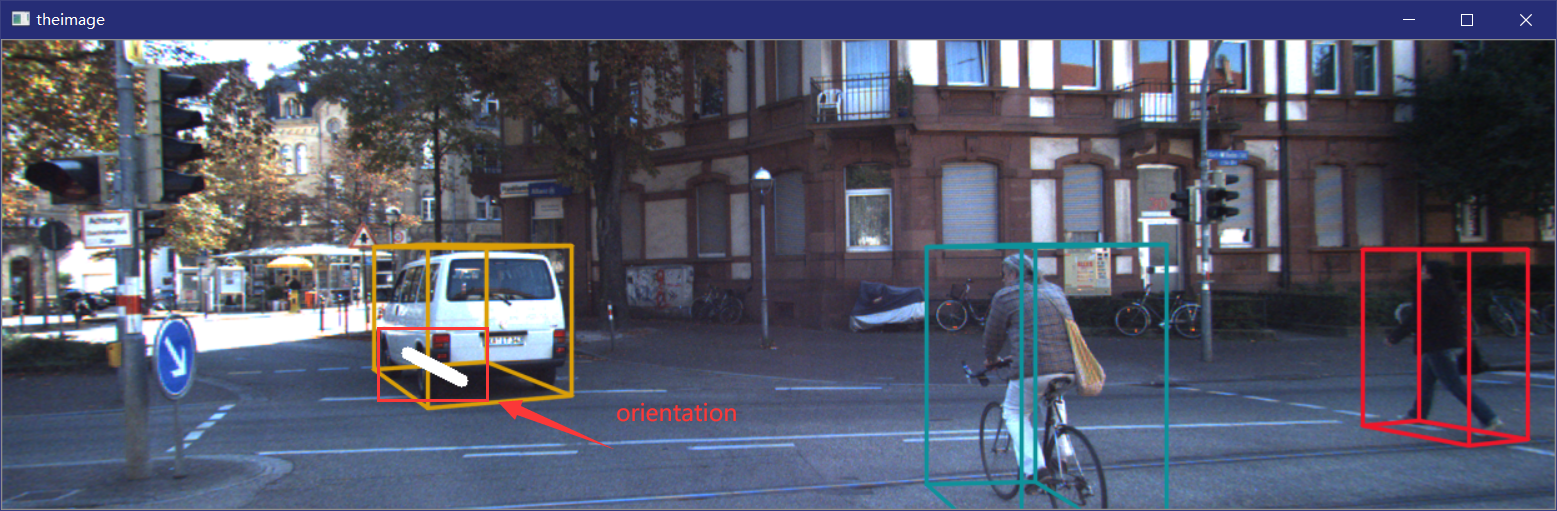

**获取深度图像 depth map**

In [67]:
depth_map = kitti_object.get_depth_map('0000', 0)

In [68]:
depth_map

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [110]:
cv2.imshow('theimage', depth_map)
cv2.waitKey(0)
cv2.destroyAllWindows()
# 注意，由于depth map是根据ptl生成的，因此数据十分稀疏，如果想要达到比较好的可视化的效果，那么有必要进行插值